# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [517]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [518]:
''' Handling timestamps'''
import datetime
from datetime import datetime

In [519]:
url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [520]:
data = data.drop(columns="Unnamed: 0").set_index("date")
data = data #[10000:]
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2011-12-31 08:00:00,4.390000,4.390000,4.390000,4.390000,0.455581,1.479329,1.479329,1.479329,1.479329
2011-12-31 16:00:00,4.490000,4.513333,4.490000,4.513333,31.620766,1.501702,1.506847,1.501702,1.506847
2012-01-01 04:00:00,4.580000,4.580000,4.580000,4.580000,1.502000,1.521699,1.521699,1.521699,1.521699
2012-01-01 16:00:00,4.840000,4.840000,4.840000,4.840000,10.000000,1.576915,1.576915,1.576915,1.576915
2012-01-01 20:00:00,5.000000,5.000000,5.000000,5.000000,10.100000,1.609438,1.609438,1.609438,1.609438
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


In [521]:
import requests
def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

## add other features

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
        data[f'dist_ema{t}'] = data['log_close'] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data['log_close'] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data


In [522]:
def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data['date'] = pd.to_datetime(data.date)
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    #    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    #    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler


def get_xgecko(length=60, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , length, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[['log_close']][-length:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[['log_close']]
    data_train_scaled, scaler = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled)
    x_gecko = np.reshape(x_gecko, (horizon, length, 1))
    return x_gecko

### Daily return

$ return = \frac{new - old}{old} $

In [523]:
data = feature_engineer(data)

In [524]:
data['4h Return'] = data['close'].pct_change()
data['4h Gradient'] = data['close'].diff()

In [525]:
data = data.dropna()

## BITCOIN Price

In [526]:
import seaborn as sns

<AxesSubplot:>

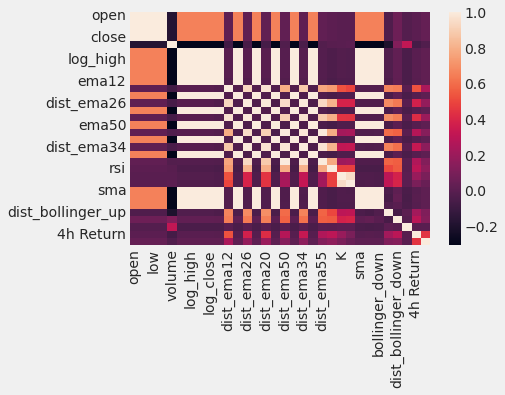

In [527]:
pd.set_option('display.max_columns', None)
sns.heatmap(data.corr())

In [528]:
data.keys()

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema20', 'dist_ema20', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'rsi', 'K', 'D', 'sma', 'bollinger_up',
       'bollinger_down', 'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc',
       '4h Return', '4h Gradient'],
      dtype='object')

In [529]:
selected_features=['log_close','4h Return', 'dist_ema20', 'dist_ema55', 'rsi', 'dist_bollinger_down', 'vol_roc']
#21,99 emas

In [530]:
selected_data = data[selected_features]
selected_data

,log_close,4h Return,dist_ema20,dist_ema55,rsi,dist_bollinger_down,vol_roc
date,,,,,,,
2012-01-10 20:00:00,1.965713,0.052580,0.099781,0.147594,68.562494,0.191808,0.656744
2012-01-11 08:00:00,1.949820,-0.014939,0.075594,0.124971,65.970885,0.150541,-0.595712
2012-01-11 12:00:00,1.974876,0.024517,0.090734,0.142476,68.023084,0.165457,0.019896
2012-01-11 16:00:00,1.938716,-0.035495,0.049215,0.101042,62.193690,0.125458,0.575566
2012-01-11 20:00:00,1.945910,0.007194,0.050887,0.102941,62.875361,0.128131,1.783596
...,...,...,...,...,...,...,...
2021-08-22 12:00:00,10.794853,-0.008789,0.013176,0.041530,62.080327,0.079495,2.306553
2021-08-22 16:00:00,10.791202,-0.003653,0.008618,0.036527,59.525060,0.061742,-0.727108
2021-08-22 20:00:00,10.795660,0.004498,0.011831,0.039521,61.603611,0.051684,0.307177


<AxesSubplot:>

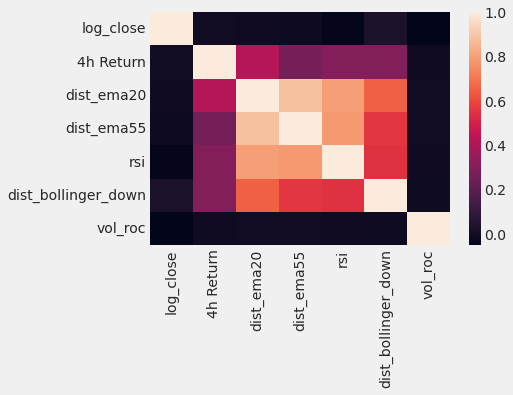

In [531]:
sns.heatmap(selected_data.corr())

In [532]:
len(selected_data)

20809

In [533]:
np.array(selected_data)[1][0]

1.9498202623235736

In [534]:
def difference(dataset, interval=1):
    dataset = np.array(dataset)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value[0])
    return pd.DataFrame(diff)

In [535]:
#selected_data = difference(selected_data, 1)

In [536]:
selected_data

,log_close,4h Return,dist_ema20,dist_ema55,rsi,dist_bollinger_down,vol_roc
date,,,,,,,
2012-01-10 20:00:00,1.965713,0.052580,0.099781,0.147594,68.562494,0.191808,0.656744
2012-01-11 08:00:00,1.949820,-0.014939,0.075594,0.124971,65.970885,0.150541,-0.595712
2012-01-11 12:00:00,1.974876,0.024517,0.090734,0.142476,68.023084,0.165457,0.019896
2012-01-11 16:00:00,1.938716,-0.035495,0.049215,0.101042,62.193690,0.125458,0.575566
2012-01-11 20:00:00,1.945910,0.007194,0.050887,0.102941,62.875361,0.128131,1.783596
...,...,...,...,...,...,...,...
2021-08-22 12:00:00,10.794853,-0.008789,0.013176,0.041530,62.080327,0.079495,2.306553
2021-08-22 16:00:00,10.791202,-0.003653,0.008618,0.036527,59.525060,0.061742,-0.727108
2021-08-22 20:00:00,10.795660,0.004498,0.011831,0.039521,61.603611,0.051684,0.307177


### Temporal Train-Test Split

In [537]:
train_percentage = 95

In [538]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

19768

In [539]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


## LSTM

In [540]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [541]:
minmax_scaler.data_max_

array([1.09649734e+01, 2.80370456e-01, 3.02535841e-01, 4.96422226e-01,
       9.71120572e+01, 8.61549292e-01, 7.55817958e+02])

In [542]:
minmax_scaler.data_min_

array([ 1.44133982, -0.36052731, -0.88516939, -0.84059691,  4.35903634,
       -0.3635051 , -0.99990566])

In [543]:
min1 = minmax_scaler.data_min_[0]
min1

1.4413398207497814

In [544]:
range1 = minmax_scaler.data_range_[0]
range1

9.523633584330872

In [545]:
data_train_scaled[:]

array([[5.50601775e-02, 6.44575757e-01, 8.29288971e-01, ...,
        6.92198023e-01, 4.53297019e-01, 2.18896790e-03],
       [5.33914327e-02, 5.39224849e-01, 8.08924471e-01, ...,
        6.64257058e-01, 4.19610456e-01, 5.34070036e-04],
       [5.60223379e-02, 6.00788897e-01, 8.21671792e-01, ...,
        6.86382468e-01, 4.31786252e-01, 1.34748629e-03],
       ...,
       [9.82403464e-01, 5.61086005e-01, 7.68737658e-01, ...,
        5.65669278e-01, 3.90835488e-01, 1.15337745e-03],
       [9.82609651e-01, 5.65602047e-01, 7.67999166e-01, ...,
        5.70521820e-01, 3.93306582e-01, 1.50196765e-03],
       [9.80733974e-01, 5.34964226e-01, 7.52227402e-01, ...,
        5.13297898e-01, 3.78372384e-01, 2.26491271e-03]])

### Creating subsequences...

In [546]:
window_size = 155 # test with small window size
horizon = 3 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size]) #add [0] for log_price to be predicted

In [547]:
np.array(fake_y_train).shape

(19611, 7)

In [548]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,0].reshape(-1,1)

In [549]:
X_train.shape

(19611, 155, 7)

In [550]:
y_train.shape

(19611, 1)

In [551]:
#with the same window_size & horizon as the train data
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [552]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,0].reshape(-1,1)

In [553]:
X_test.shape

(884, 155, 7)

In [554]:
y_test.shape

(884, 1)

### LSTM

#### RNN Architecture

In [555]:
pd.DataFrame(y_test).shape

(884, 1)

In [556]:
from tensorflow.keras import metrics

my_mae = metrics.MeanAbsoluteError(
    name='mean_absolute_error', dtype=None
)


In [562]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"
                    #activation = "relu"
                     #input_shape = X_train[0].shape)
                     ))

model.add(layers.LSTM(units=64,
                      return_sequences = False,
                      activation = "relu"  
                    #activation = "relu"
                     ))

# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,
                        activation = "tanh" 
                       #activation="relu"
                      ))
#model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(8,
                       activation = "relu"
                       #activation="relu"
                      ))
model.add(layers.Dense(1,
                      activation = "relu" 
                      #activation="relu"
                      ))

#model.summary()



In [563]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [564]:
#### perhaps create a validation and train sets by hand

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 

es = EarlyStopping(patience = 5, 
                   restore_best_weights= True
                   #monitor = "val_mean_absolute_error"
                  )

history = model.fit(X_train, y_train,
          validation_split = 0.3,
         batch_size=8,
         epochs=20,
         verbose = 1,
         callbacks = [es]
                   )

Epoch 1/20
1716/1716 [==============================] - 189s 109ms/step - loss: 0.0022 - mae: 0.0129 - val_loss: 3.1546e-05 - val_mae: 0.0034
Epoch 2/20
1716/1716 [==============================] - 190s 111ms/step - loss: 6.2578e-05 - mae: 0.0058 - val_loss: 5.1545e-05 - val_mae: 0.0063
Epoch 3/20
1716/1716 [==============================] - 190s 111ms/step - loss: 4.7113e-05 - mae: 0.0049 - val_loss: 4.2603e-05 - val_mae: 0.0062
Epoch 4/20
 429/1716 [======>.......................] - ETA: 2:43 - loss: 3.8531e-05 - mae: 0.0048

In [473]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

#     ax[1].plot(history.history['mean_absolute_error'])
#     ax[1].plot(history.history['val_mean_absolute_error'])
#     ax[1].set_title('Model MAE', fontsize = 18)
#     ax[1].set_xlabel('Epoch', fontsize = 14)
#     ax[1].set_ylabel('Recall', fontsize = 14)
#     ax[1].legend(['Train', 'Val'], loc='lower right') 
#     ax[1].grid(axis="x",linewidth=0.5)
#     ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

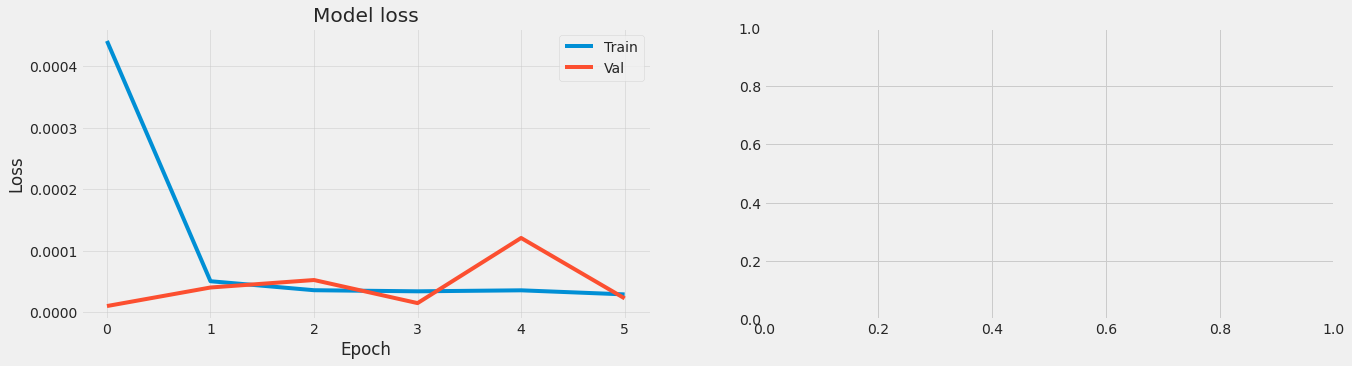

In [474]:
plot_loss_mae(history)

#### Evaluating

In [475]:
res = model.evaluate(X_test, np.array(y_test), verbose = 1)
res


28/28 [==============================] - 1s 37ms/step - loss: 1.1802e-04 - mae: 0.0102


[0.00011801854998338968, 0.010184316895902157]

#### Predictions

In [476]:
predictions = model.predict(X_test)


In [477]:
len(predictions), len(y_test)

(882, 882)

In [478]:
predictions[0:3]

array([[0.9848725 ],
       [0.98463017],
       [0.9843016 ]], dtype=float32)

In [479]:
y_test_unscaled = y_test * range1 + min1

In [480]:
predictions_unscaled = predictions * range1 + min1

In [481]:
predictions_unscaled[0:3]

array([[10.820905],
       [10.818597],
       [10.815468]], dtype=float32)

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [482]:
mae = np.mean(np.abs(y_test_unscaled - predictions_unscaled))
mae

0.09699169228962523

In [483]:
np.exp(mae)

1.1018512197221773

In [484]:
df =pd.DataFrame()
df['y_test'] = pd.DataFrame(y_test_unscaled).apply(lambda x: np.exp(x))
df['pred'] = pd.DataFrame(predictions_unscaled).apply(lambda x: np.exp(x))
df['diff'] = df['y_test'] - df['pred']

In [485]:
df

,y_test,pred,diff
0,55468.056761,50056.351562,5411.705199
1,55286.039330,49940.960938,5345.078392
2,56233.725168,49784.941406,6448.783762
3,57991.049009,50086.535156,7904.513853
4,57841.287773,50934.121094,6907.166679
...,...,...,...
877,49133.932348,45018.359375,4115.572973
878,49202.055472,45040.644531,4161.410941
879,48769.127815,45113.339844,3655.787972
880,48591.428238,44944.402344,3647.025894


In [486]:
np.mean(np.abs(df['diff']))

4206.130204103629

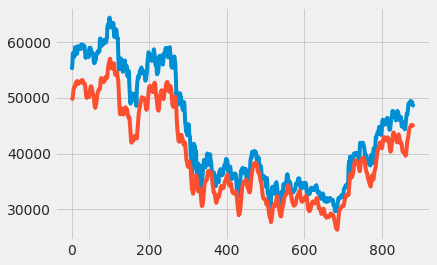

In [487]:
plt.plot(df[['y_test', 'pred']])

# PREDICTION WITH COINGECKO!!!

In [488]:
import requests

def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api

def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

In [489]:
coingecko = feature_engineer(get_coingecko())
coingecko['4h Return'] = coingecko['close'].pct_change()
x_gecko = coingecko[selected_features][-160:]
x_gecko_scaled = minmax_scaler.transform(x_gecko)

In [490]:
x_gecko

,log_close,4h Return,dist_ema20,dist_ema55,rsi,dist_bollinger_down,vol_roc
2021-08-03 04:00:00,10.573690,-0.009308,-0.031968,-0.038735,35.814340,0.002638,0.010942
2021-08-03 08:00:00,10.557756,-0.015808,-0.042773,-0.051124,30.758919,-0.002926,-0.009507
2021-08-03 12:00:00,10.567042,0.009330,-0.029943,-0.039202,36.393871,0.012273,0.000841
2021-08-03 16:00:00,10.555880,-0.011100,-0.036801,-0.047275,32.925295,0.008924,0.028388
2021-08-03 20:00:00,10.549674,-0.006186,-0.038545,-0.050281,31.148052,0.010103,-0.010540
...,...,...,...,...,...,...,...
2021-08-29 00:00:00,10.795143,-0.002932,0.007531,0.015203,55.011229,0.048741,-0.028060
2021-08-29 04:00:00,10.795556,0.000414,0.007188,0.015058,55.228478,0.049057,0.039152
2021-08-29 08:00:00,10.789489,-0.006050,0.001013,0.008668,51.313312,0.042828,-0.004283
2021-08-29 12:00:00,10.793221,0.003739,0.004293,0.011957,53.496809,0.046544,-0.014827


In [491]:
coingecko[-3:]

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,dist_ema12,ema26,dist_ema26,ema20,dist_ema20,ema50,dist_ema50,ema34,dist_ema34,ema55,dist_ema55,rsi,K,D,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return
2021-08-29 08:00:00,48346.04,48508.22,48259.33,48508.22,2.914709e+10,10.786140,10.789489,10.784344,10.789489,10.790697,-0.001208,10.787550,0.001939,10.788475,0.001013,10.782330,0.007159,10.786232,0.003256,10.780820,0.008668,51.313312,70.315685,76.483480,10.781271,10.815882,10.746660,-0.026393,0.042828,-0.004283,-0.006050
2021-08-29 12:00:00,48563.96,48689.59,48545.06,48689.59,2.871492e+10,10.790637,10.793221,10.790248,10.793221,10.791085,0.002135,10.787970,0.005251,10.788927,0.004293,10.782757,0.010463,10.786632,0.006589,10.781264,0.011957,53.496809,66.984073,72.664521,10.781239,10.815802,10.746676,-0.022581,0.046544,-0.014827,0.003739
2021-08-29 16:00:00,48285.52,48483.18,48285.52,48456.12,2.722290e+10,10.784887,10.788972,10.784887,10.788414,10.790674,-0.002260,10.788003,0.000411,10.788878,-0.000464,10.782979,0.005435,10.786733,0.001680,10.781520,0.006894,50.363918,54.730353,64.010037,10.782774,10.815622,10.749925,-0.027208,0.038489,-0.051960,-0.004795


In [509]:
window_size=155

In [510]:
x_gecko_subsequences = []
for k in range(len(x_gecko_scaled)-(window_size-1)-horizon):
    x_gecko_subsequences.append(x_gecko_scaled[k:k+window_size])

In [511]:
x_gecko = np.array(x_gecko_subsequences)

In [512]:
x_gecko.shape

(3, 155, 7)

In [513]:
#x_gecko = np.array(x_gecko)
x_gecko = np.reshape(x_gecko, (-1,window_size,len(selected_features))) #[-horizon:,:,:]

x_gecko.shape

(3, 155, 7)

In [514]:
predictions = model.predict(x_gecko)

predictions

array([[0.97153085],
       [0.9713752 ],
       [0.9713058 ]], dtype=float32)

In [515]:
predictions_unscaled = predictions * range1 + min1

In [516]:
np.exp(predictions_unscaled)

array([[44083.633],
       [44018.348],
       [43989.223]], dtype=float32)

In [330]:
from datetime import datetime
dateTimeObj = datetime.now()
print(dateTimeObj)

2021-08-29 14:20:59.740650


In [331]:
close = pd.DataFrame(coingecko.close[-10:].reset_index().drop(columns='index'))

In [335]:
close

,close
0,49060.62
1,48986.02
2,49037.10
3,48931.53
4,48552.28
5,48926.73
6,48783.28
7,48803.46
8,48508.22
9,48689.59


In [333]:
for i in range(len(close),len(close) + horizon):
    print(i)

10
11
12
13
14
15


In [334]:
pred = pd.DataFrame(np.exp(predictions_unscaled), columns = ['close']).set_index(pd.Index(range(len(close),len(close) + horizon)))

ValueError: Length mismatch: Expected 115 rows, received array of length 6

In [345]:
df = pd.DataFrame(np.exp(predictions_unscaled), columns = ['pred'])
df['gecko'] = coingecko['log_close']
df

,pred,gecko
0,46316.378906,NaN
1,46207.839844,NaN
2,47056.429688,NaN
3,46594.683594,NaN
4,46318.496094,NaN
...,...,...
110,48516.605469,NaN
111,49213.468750,NaN
112,48992.253906,NaN
113,48946.070312,NaN


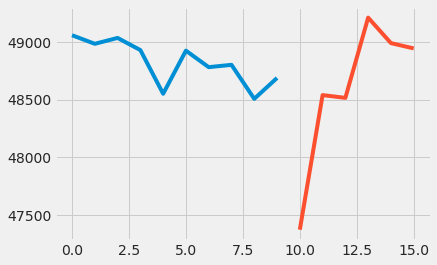

In [337]:
plt.plot(close)
plt.plot(pred)

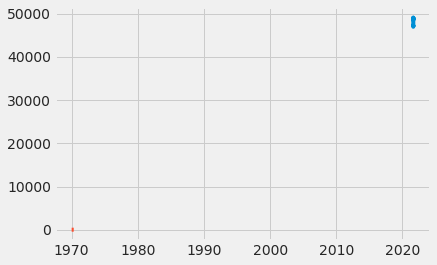

In [338]:
plt.plot(coingecko['close'][-20:])
plt.plot(predictions_unscaled)